### Capstone Notebook
This notebook is used for the Capstone project!

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0

Import PLoting library


In [2]:
# we are using the inline backend
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
print(plt.style.available)
mpl.style.use(['ggplot']) # optional: for ggplot-like style

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


## Function to Return Latitude and Longitude of a given Address

In [3]:
def returnLatLon(address):
    LatLon = []
    address = address

    geolocator = Nominatim(user_agent= address+"_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    LatLon.append(latitude)
    longitude = location.longitude
    LatLon.append(longitude)
    
    return LatLon


## Function to create map of a city with its Neighborhoods superimposed on top 

In [4]:
def plotCity(City_lat, City_lon, neighborhoods):
    map_newyork = folium.Map(location=[City_lat, City_lon], zoom_start=10)

    # add markers to map
    for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
        label = '{}, {}'.format(neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_newyork)  

    return map_newyork

Viualize City Cluster

In [5]:
def plotCluster(city_lat, city_lon, clusterData):
    
    # create map
    map_clusters = folium.Map(location=[city_lat, city_lon], zoom_start=11)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(clusterData['Latitude'], clusterData['Longitude'], clusterData['Neighborhood'], clusterData['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

    return map_clusters

## Define FourSquare Credentials

In [6]:
CLIENT_ID = 'TYTATKL2Z01PHMKDVJUN32V1OUQHYUMKQVJFAR11NVOR4R12' # your Foursquare ID
CLIENT_SECRET = '5EZLKAHX3SAKU45TTZACCOQYW0ZDUFT4G30AECZFMS32CVJ0' # your Foursquare Secret
VERSION = '20200623' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TYTATKL2Z01PHMKDVJUN32V1OUQHYUMKQVJFAR11NVOR4R12
CLIENT_SECRET:5EZLKAHX3SAKU45TTZACCOQYW0ZDUFT4G30AECZFMS32CVJ0


## Function to Explore Neighborhoods in a city

In [7]:
LIMIT = 100

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Function to create a new dataframe and display the top ten Venues for each Neighborhood

In [9]:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [10]:
def return_sorted(city_grouped):


    num_top_venues = 10

    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['Neighborhood'] = city_grouped['Neighborhood']

    for ind in np.arange(city_grouped.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

    return neighborhoods_venues_sorted

## Funciton to create Onehot Encoding

In [11]:
def returnOnehot(city_venues):
    # one hot encoding
    city_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    city_onehot['Neighborhood'] = city_venues['Neighborhood'] 
    Neighborhood_col = city_onehot['Neighborhood']
    city_onehot.drop(labels=['Neighborhood'], axis=1, inplace = True)
    city_onehot.insert(0, 'Neighborhood', Neighborhood_col)
    return city_onehot

# Download and Explore Dataset

# 1. Toronto DataSet

In [12]:
!conda install --yes -c anaconda beautifulsoup4 #install BeautifulSoup to extract html files

from urllib.request import urlopen #used to open URLs
from bs4 import BeautifulSoup

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.9.1       |           py36_0         168 KB  anaconda
    ca-certificates-2020.7.22  |                0         132 KB  anaconda
    certifi-2020.6.20          |           py36_0         160 KB  anaconda
    openssl-1.1.1g             |       h7b6447c_0         3.8 MB  anaconda
    soupsieve-2.0.1            |             py_0          33 KB  anaconda
    ------------------------------------------------------------
                                           Total:         4.3 MB

The following 

In [13]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M" #url of List of postal codes
html = urlopen(url)

In [14]:
#!pip install lxml #Install lxml then restart the kernel and comment the install command
soup = BeautifulSoup(html, 'lxml') #
type(soup)


bs4.BeautifulSoup

In [15]:
tables = soup.find_all('table')
table = tables[:1]
rows = soup.table.find_all('tr') 
#import re
list_rows = []
for row in rows:
    cells = row.find_all('td')
    str_cells = str(cells)
    text = BeautifulSoup(str_cells, 'lxml').get_text()
    list_rows.append(text)
df = pd.DataFrame(list_rows)
df.head()

0
0                                         []
1    [M1A\n, Not assigned\n, Not assigned\n]
2    [M2A\n, Not assigned\n, Not assigned\n]
3         [M3A\n, North York\n, Parkwoods\n]
4  [M4A\n, North York\n, Victoria Village\n]

Rearange the dataframe

In [16]:
df1 = df[0].str.split('\n', expand=True)
df1[0] = df1[0].str.strip('[') #remove [ mark from the first row
df1.head()

0               1                   2     3
0    ]            None                None  None
1  M1A  , Not assigned      , Not assigned     ]
2  M2A  , Not assigned      , Not assigned     ]
3  M3A    , North York         , Parkwoods     ]
4  M4A    , North York  , Victoria Village     ]

Read the column names from the web

In [17]:
col_labels = soup.table.find_all('th') # Find the column names
all_header = []
col_str = str(col_labels)
cleantext2 = BeautifulSoup(col_str, "lxml").get_text()
all_header.append(cleantext2)
print(all_header)

['[Postal Code\n, Community\n, Neighbourhood\n]']


In [18]:
df2 = pd.DataFrame(all_header)
df3 = df2[0].str.split(',', expand=True) #split the column names using comma 


Merge the column names with the dataframe

In [19]:
frames = [df3, df1]

df4 = pd.concat(frames) # concatnate the column names with the data
df4.head(10)

0                   1  \
0  [Postal Code\n         Community\n   
0               ]                None   
1             M1A      , Not assigned   
2             M2A      , Not assigned   
3             M3A        , North York   
4             M4A        , North York   
5             M5A  , Downtown Toronto   
6             M6A        , North York   
7             M7A  , Downtown Toronto   
8             M8A      , Not assigned   

                                               2     3  
0                               Neighbourhood\n]   NaN  
0                                           None  None  
1                                 , Not assigned     ]  
2                                 , Not assigned     ]  
3                                    , Parkwoods     ]  
4                             , Victoria Village     ]  
5                    , Regent Park, Harbourfront     ]  
6             , Lawrence Manor, Lawrence Heights     ]  
7  , Queen's Park, Ontario Provincial Government     ]  
8                                 , Not assigned     ]

Correct the merged dataframe 

In [20]:
df5 = df4.rename(columns=df4.iloc[0])
df7 = df5.drop(df5.index[0]) #remove the first row which is a duplicated value for the column names
df7.columns = df7.columns.str.replace('\n', '') #replace the line break with empty value
df7.columns = df7.columns.str.replace('[', '')  #replace [ with empty value
df7.columns = df7.columns.str.replace(']', '')  #replace ] with empty value
df7.head()

Postal Code           Community                Neighbourhood NaN
1         M1A      , Not assigned               , Not assigned   ]
2         M2A      , Not assigned               , Not assigned   ]
3         M3A        , North York                  , Parkwoods   ]
4         M4A        , North York           , Victoria Village   ]
5         M5A  , Downtown Toronto  , Regent Park, Harbourfront   ]

In [21]:
df7.rename(columns={'Postal Code': 'PostalCode', ' Community':'Borough', ' Neighbourhood':'Neighborhood'},inplace=True) #correct name of columns according to the required names
df7 = df7[['PostalCode', 'Borough', 'Neighborhood']] #remove the last column which we are not interested

df7.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


PostalCode             Borough                 Neighborhood
1        M1A      , Not assigned               , Not assigned
2        M2A      , Not assigned               , Not assigned
3        M3A        , North York                  , Parkwoods
4        M4A        , North York           , Victoria Village
5        M5A  , Downtown Toronto  , Regent Park, Harbourfront

In [22]:
df7['Borough'] = df7['Borough'].str.strip(',') # strip comma from Borough column
#Strip the first comma from Neighborhood
df7['Neighborhood'] = df7['Neighborhood'].str[1:] #Since we get extra column at the first position of each value we remove comma

#Strip the space in the front
df7['Borough'] = df7['Borough'].str[1:] #remove Extra space which is at the first position
df7.head()

PostalCode           Borough                Neighborhood
1        M1A      Not assigned                Not assigned
2        M2A      Not assigned                Not assigned
3        M3A        North York                   Parkwoods
4        M4A        North York            Victoria Village
5        M5A  Downtown Toronto   Regent Park, Harbourfront

In [23]:
df7.drop(df7[df7['Borough'] == 'Not assigned'].index, inplace = True) #Remove all Boroughs with Not assigned value


df7.head()

PostalCode           Borough                                  Neighborhood
3        M3A        North York                                     Parkwoods
4        M4A        North York                              Victoria Village
5        M5A  Downtown Toronto                     Regent Park, Harbourfront
6        M6A        North York              Lawrence Manor, Lawrence Heights
7        M7A  Downtown Toronto   Queen's Park, Ontario Provincial Government

In [24]:
df7.reset_index(drop = True, inplace = True)


In [25]:
df7.head()

PostalCode           Borough                                  Neighborhood
0        M3A        North York                                     Parkwoods
1        M4A        North York                              Victoria Village
2        M5A  Downtown Toronto                     Regent Park, Harbourfront
3        M6A        North York              Lawrence Manor, Lawrence Heights
4        M7A  Downtown Toronto   Queen's Park, Ontario Provincial Government

In [26]:
#check if Neighborhood has 'Not assigned' value
df7[df7['Neighborhood'] == 'Not assigned'].index

Int64Index([], dtype='int64')

Since there is not assigned Neighborhood, it's ok to work on this data frame

Access the geographical coordinates of the Postalcodes

In [27]:
geoLoc = pd.read_csv('http://cocl.us/Geospatial_data')
geoLoc.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

In [28]:
geoLoc.rename(columns = {'Postal Code': 'PostalCode'}, inplace = True)
# merge the two data frames based on Postal code
Toronto = pd.merge(df7, geoLoc)
Toronto.head()

PostalCode           Borough                                  Neighborhood  \
0        M3A        North York                                     Parkwoods   
1        M4A        North York                              Victoria Village   
2        M5A  Downtown Toronto                     Regent Park, Harbourfront   
3        M6A        North York              Lawrence Manor, Lawrence Heights   
4        M7A  Downtown Toronto   Queen's Park, Ontario Provincial Government   

    Latitude  Longitude  
0  43.753259 -79.329656  
1  43.725882 -79.315572  
2  43.654260 -79.360636  
3  43.718518 -79.464763  
4  43.662301 -79.389494

In [29]:
geoLoc.head(15)

PostalCode   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476
5         M1J  43.744734 -79.239476
6         M1K  43.727929 -79.262029
7         M1L  43.711112 -79.284577
8         M1M  43.716316 -79.239476
9         M1N  43.692657 -79.264848
10        M1P  43.757410 -79.273304
11        M1R  43.750072 -79.295849
12        M1S  43.794200 -79.262029
13        M1T  43.781638 -79.304302
14        M1V  43.815252 -79.284577

In [30]:
Toronto.shape

(103, 5)

In [31]:
print(len(Toronto['PostalCode'].unique()))
print(len(Toronto['Borough'].unique()))


103
10


Reterive the latitude and Longitude of Toronto

In [32]:
LatLon_Toronto = returnLatLon('Toronto')
T_lat = LatLon_Toronto[0]
T_lon = LatLon_Toronto[1]

print('The geograpical coordinates of Toronto are latitude = {}, Longitude = {}.'.format(T_lat, T_lon))

The geograpical coordinates of Toronto are latitude = 43.6534817, Longitude = -79.3839347.


In [33]:
plotCity(T_lat, T_lon, Toronto)

# Explore Neighborhoods in Toronto

In [34]:

Toronto_venues = getNearbyVenues(names=Toronto['PostalCode'],
                                   latitudes=Toronto['Latitude'],
                                   longitudes=Toronto['Longitude']
                                  )


In [35]:
print(Toronto_venues.shape)
Toronto_venues.head()

(2146, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0          M3A              43.753259              -79.329656   
1          M3A              43.753259              -79.329656   
2          M4A              43.725882              -79.315572   
3          M4A              43.725882              -79.315572   
4          M4A              43.725882              -79.315572   

                    Venue  Venue Latitude  Venue Longitude  \
0         Brookbanks Park       43.751976       -79.332140   
1           Variety Store       43.751974       -79.333114   
2  Victoria Village Arena       43.723481       -79.315635   
3               Portugril       43.725819       -79.312785   
4             Tim Hortons       43.725517       -79.313103   

          Venue Category  
0                   Park  
1      Food & Drink Shop  
2           Hockey Arena  
3  Portuguese Restaurant  
4            Coffee Shop

### Determine the 10 top Venue Category in Toronto

In [36]:
T_venue_category = Toronto_venues[['Venue Category']]
T_venue_category.head()

Venue Category
0                   Park
1      Food & Drink Shop
2           Hockey Arena
3  Portuguese Restaurant
4            Coffee Shop

In [37]:
T_top_10_venues = T_venue_category['Venue Category'].value_counts().to_frame().head(10)
T_top_10_venues.rename(columns = {'Venue Category':'Toronto'}, inplace = True)
T_top_10_venues.index.name = 'Venue Category'

T_top_10_venues

Toronto
Venue Category              
Coffee Shop              190
Café                      93
Restaurant                66
Park                      51
Pizza Place               49
Hotel                     45
Sandwich Place            43
Bakery                    42
Japanese Restaurant       41
Italian Restaurant        39

Check how many venues retured for each neighborhood

In [38]:
Toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                         
M1B                               1                       1      1   
M1C                               2                       2      2   
M1E                               8                       8      8   
M1G                               4                       4      4   
M1H                               8                       8      8   
M1J                               3                       3      3   
M1K                               4                       4      4   
M1L                              10                      10     10   
M1M                               2                       2      2   
M1N                               4                       4      4   
M1P                               5                       5      5   
M1R                               6                       6      6   
M1S                               5                       5      5   
M1T                              12                      12     12   
M1V                               3                       3      3   
M1W                              12                      12     12   
M2H                               5                       5      5   
M2J                              70                      70     70   
M2K                               4                       4      4   
M2L                               1                       1      1   
M2N                              33                      33     33   
M2P                               2                       2      2   
M2R                               5                       5      5   
M3A                               2                       2      2   
M3B                               4                       4      4   
M3C                              19                      19     19   
M3H                              21                      21     21   
M3J                               7                       7      7   
M3K                               2                       2      2   
M3L                               6                       6      6   
M3M                               4                       4      4   
M3N                               4                       4      4   
M4A                               5                       5      5   
M4B                              10                      10     10   
M4C                               7                       7      7   
M4E                               4                       4      4   
M4G                              33                      33     33   
M4H                              24                      24     24   
M4J                               3                       3      3   
M4K                              43                      43     43   
M4L                              19                      19     19   
M4M                              37                      37     37   
M4N                               3                       3      3   
M4P                               9                       9      9   
M4R                              18                      18     18   
M4S                              33                      33     33   
M4T                               2                       2      2   
M4V                              15                      15     15   
M4W                               4                       4      4   
M4X                              49                      49     49   
M4Y                              77                      77     77   
M5A                              44                      44     44   
M5B                             100                     100    100   
M5C                              86                      86     86   
M5E                              55                      55     55   
M5G                     

In [39]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 273 uniques categories.


## Determine how many venues are returend per Borough

In [40]:
Toronto.drop('Neighborhood', axis = 1, inplace = True)
Toronto.rename(columns = {'PostalCode': 'Neighborhood'}, inplace = True)
Toronto.head()

Neighborhood           Borough   Latitude  Longitude
0          M3A        North York  43.753259 -79.329656
1          M4A        North York  43.725882 -79.315572
2          M5A  Downtown Toronto  43.654260 -79.360636
3          M6A        North York  43.718518 -79.464763
4          M7A  Downtown Toronto  43.662301 -79.389494

In [41]:
Toronto_b_merged = Toronto
Toronto_b_merged = Toronto_b_merged.join(Toronto_venues.set_index('Neighborhood'), on='Neighborhood')
Toronto_b_merged.head()

Neighborhood     Borough   Latitude  Longitude  Neighborhood Latitude  \
0          M3A  North York  43.753259 -79.329656              43.753259   
0          M3A  North York  43.753259 -79.329656              43.753259   
1          M4A  North York  43.725882 -79.315572              43.725882   
1          M4A  North York  43.725882 -79.315572              43.725882   
1          M4A  North York  43.725882 -79.315572              43.725882   

   Neighborhood Longitude                   Venue  Venue Latitude  \
0              -79.329656         Brookbanks Park       43.751976   
0              -79.329656           Variety Store       43.751974   
1              -79.315572  Victoria Village Arena       43.723481   
1              -79.315572               Portugril       43.725819   
1              -79.315572             Tim Hortons       43.725517   

   Venue Longitude         Venue Category  
0       -79.332140                   Park  
0       -79.333114      Food & Drink Shop  
1       -79.315635           Hockey Arena  
1       -79.312785  Portuguese Restaurant  
1       -79.313103            Coffee Shop

In [42]:
Toronto_b_merged.shape

(2149, 10)

In [43]:
Toronto_b_merged = Toronto_b_merged[['Borough', 'Venue']]
Toronto_b_merged = Toronto_b_merged.groupby('Borough').count()
Toronto_b_merged

Venue
Borough                
Central Toronto     105
Downtown Toronto   1257
East Toronto        119
East York            77
Etobicoke            74
Mississauga          13
North York          239
Scarborough          89
West Toronto        154
York                 19

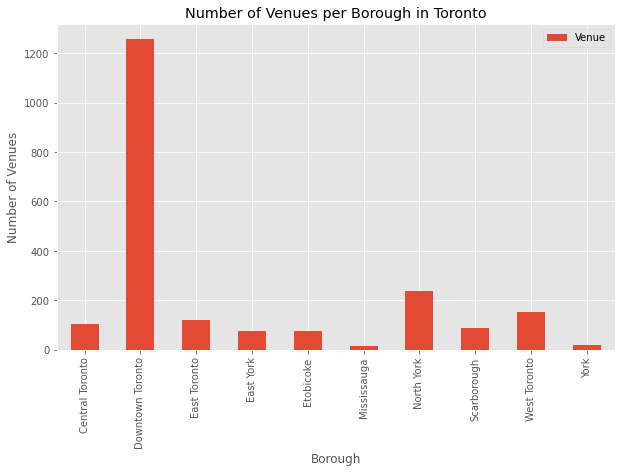

In [44]:
# step 2: plot data
Toronto_b_merged.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Borough') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Number of Venues per Borough in Toronto') # add title to the plot

plt.show()

## Analyze each Neighborhood

In [45]:
Toronto_onehot = returnOnehot(Toronto_venues)
Toronto_onehot.head()


Neighborhood  Accessories Store  Afghan Restaurant  Airport  \
0          M3A                  0                  0        0   
1          M3A                  0                  0        0   
2          M4A                  0                  0        0   
3          M4A                  0                  0        0   
4          M4A                  0                  0        0   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0                   0             0               0                0   
1                   0             0               0                0   
2                   0             0               0                0   
3                   0             0               0                0   
4                   0             0               0                0   

   Airport Terminal  American Restaurant  Antique Shop  Aquarium  Art Gallery  \
0                 0                    0             0         0            0   
1                 0                    0             0         0            0   
2                 0                    0             0         0            0   
3                 0                    0             0         0            0   
4                 0                    0             0         0            0   

   Art Museum  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0           0                    0                 0                   0   
1           0                    0                 0                   0   
2           0                    0                 0                   0   
3           0                    0                 0                   0   
4           0                    0                 0                   0   

   Auto Garage  Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  \
0            0              0          0           0           0       0   
1            0              0          0           0           0       0   
2            0              0          0           0           0       0   
3            0              0          0           0           0       0   
4            0              0          0           0           0       0   

   Bank  Bar  Baseball Field  Baseball Stadium  Basketball Stadium  Beach  \
0     0    0               0                 0                   0      0   
1     0    0               0                 0                   0      0   
2     0    0               0                 0                   0      0   
3     0    0               0                 0                   0      0   
4     0    0               0                 0                   0      0   

   Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  Bike Shop  \
0                0         0           0                   0          0   
1                0         0           0                   0          0   
2                0         0           0                   0          0   
3                0         0           0                   0          0   
4                0         0           0                   0          0   

   Bistro  Boat or Ferry  Bookstore  Boutique  Brazilian Restaurant  \
0       0              0          0         0                     0   
1       0              0          0         0                     0   
2       0              0          0         0                     0   
3       0              0          0         0                     0   
4       0              0          0         0                     0   

   Breakfast Spot  Brewery  Bridal Shop  Bubble Tea Shop  Building  \
0               0        0            0                0         0   
1               0        0            0                0         0   
2               0        0            0                0         0   
3               0        0            0                0         0   
4               0        0            0                0         0   

   Burger Joint

Group by Neighborhood

In [46]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

Neighborhood  Accessories Store  Afghan Restaurant  Airport  \
0           M1B           0.000000           0.000000   0.0000   
1           M1C           0.000000           0.000000   0.0000   
2           M1E           0.000000           0.000000   0.0000   
3           M1G           0.000000           0.000000   0.0000   
4           M1H           0.000000           0.000000   0.0000   
5           M1J           0.000000           0.000000   0.0000   
6           M1K           0.000000           0.000000   0.0000   
7           M1L           0.000000           0.000000   0.0000   
8           M1M           0.000000           0.000000   0.0000   
9           M1N           0.000000           0.000000   0.0000   
10          M1P           0.000000           0.000000   0.0000   
11          M1R           0.166667           0.000000   0.0000   
12          M1S           0.000000           0.000000   0.0000   
13          M1T           0.000000           0.000000   0.0000   
14          M1V           0.000000           0.000000   0.0000   
15          M1W           0.000000           0.000000   0.0000   
16          M2H           0.000000           0.000000   0.0000   
17          M2J           0.000000           0.000000   0.0000   
18          M2K           0.000000           0.000000   0.0000   
19          M2L           0.000000           0.000000   0.0000   
20          M2N           0.000000           0.000000   0.0000   
21          M2P           0.000000           0.000000   0.0000   
22          M2R           0.000000           0.000000   0.0000   
23          M3A           0.000000           0.000000   0.0000   
24          M3B           0.000000           0.000000   0.0000   
25          M3C           0.000000           0.000000   0.0000   
26          M3H           0.000000           0.000000   0.0000   
27          M3J           0.000000           0.000000   0.0000   
28          M3K           0.000000           0.000000   0.5000   
29          M3L           0.000000           0.000000   0.0000   
30          M3M           0.000000           0.000000   0.0000   
31          M3N           0.000000           0.000000   0.0000   
32          M4A           0.000000           0.000000   0.0000   
33          M4B           0.000000           0.000000   0.0000   
34          M4C           0.000000           0.000000   0.0000   
35          M4E           0.000000           0.000000   0.0000   
36          M4G           0.000000           0.000000   0.0000   
37          M4H           0.000000           0.000000   0.0000   
38          M4J           0.000000           0.000000   0.0000   
39          M4K           0.000000           0.000000   0.0000   
40          M4L           0.000000           0.000000   0.0000   
41          M4M           0.000000           0.000000   0.0000   
42          M4N           0.000000           0.000000   0.0000   
43          M4P           0.000000           0.000000   0.0000   
44          M4R           0.000000           0.000000   0.0000   
45          M4S           0.000000           0.000000   0.0000   
46          M4T           0.000000           0.000000   0.0000   
47          M4V           0.000000           0.000000   0.0000   
48          M4W           0.000000           0.000000   0.0000   
49          M4X           0.000000           0.000000   0.0000   
50          M4Y           0.000000           0.012987   0.0000   
51          M5A           0.000000           0.000000   0.0000   
52          M5B           0.000000           0.000000   0.0000   
53          M5C           0.000000           0.000000   0.0000   
54          M5E           0.000000           0.000000   0.0000   
55          M5G           0.000000           0.000000   0.0000   
56          M5H           0.000000           0.000000   0.0000   
57          M5J           0.000000           0.000000   0.0000   
58          M5K           0.000000           0.000000   0.0000   
59          M5L           0.000000         

Findout the 10 most common venues in each neighborhood

In [47]:
Toronto_venues_sorted = return_sorted(Toronto_grouped)
Toronto_venues_sorted.head()

Neighborhood       1st Most Common Venue 2nd Most Common Venue  \
0          M1B        Fast Food Restaurant             Drugstore   
1          M1C  Construction & Landscaping                   Bar   
2          M1E              Breakfast Spot     Electronics Store   
3          M1G                 Coffee Shop     Korean Restaurant   
4          M1H            Hakka Restaurant                Bakery   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                 Diner        Discount Store   Distribution Center   
1           Yoga Studio   Dumpling Restaurant   Distribution Center   
2            Restaurant        Medical Center   Rental Car Location   
3    Mexican Restaurant             Drugstore        Discount Store   
4                  Bank    Athletics & Sports           Gas Station   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0               Dog Run      Doner Restaurant            Donut Shop   
1               Dog Run      Doner Restaurant            Donut Shop   
2          Intersection    Mexican Restaurant                  Bank   
3   Distribution Center               Dog Run      Doner Restaurant   
4       Thai Restaurant  Caribbean Restaurant   Fried Chicken Joint   

  9th Most Common Venue       10th Most Common Venue  
0   Dumpling Restaurant                Women's Store  
1             Drugstore  Eastern European Restaurant  
2           Yoga Studio          Distribution Center  
3            Donut Shop                  Yoga Studio  
4               Dog Run          Distribution Center

### Cluster Neighborhoods

In [48]:
# set number of clusters
kclusters = 5

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 


# add clustering labels
Toronto_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = Toronto
# merge Toronto_grouped with Toronto_dataset to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(Toronto_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


Toronto_merged.head()

Neighborhood           Borough   Latitude  Longitude  Cluster Labels  \
0          M3A        North York  43.753259 -79.329656             1.0   
1          M4A        North York  43.725882 -79.315572             2.0   
2          M5A  Downtown Toronto  43.654260 -79.360636             2.0   
3          M6A        North York  43.718518 -79.464763             2.0   
4          M7A  Downtown Toronto  43.662301 -79.389494             2.0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0     Food & Drink Shop                  Park             Drugstore   
1           Pizza Place           Coffee Shop          Hockey Arena   
2           Coffee Shop                  Park                   Pub   
3        Clothing Store     Accessories Store              Boutique   
4           Coffee Shop           Yoga Studio                  Bank   

   4th Most Common Venue   5th Most Common Venue        6th Most Common Venue  \
0                  Diner          Discount Store          Distribution Center   
1  Portuguese Restaurant            Intersection  Eastern European Restaurant   
2                 Bakery                    Café               Breakfast Spot   
3              Gift Shop  Furniture / Home Store                  Event Space   
4               Beer Bar           Smoothie Shop               Sandwich Place   

  7th Most Common Venue 8th Most Common Venue  9th Most Common Venue  \
0               Dog Run      Doner Restaurant             Donut Shop   
1     Electronics Store           Escape Room   Ethiopian Restaurant   
2               Theater            Shoe Store      French Restaurant   
3           Coffee Shop         Women's Store  Vietnamese Restaurant   
4            Restaurant                  Café     Chinese Restaurant   

  10th Most Common Venue  
0            Yoga Studio  
1    Dumpling Restaurant  
2             Beer Store  
3        Airport Service  
4  Portuguese Restaurant

In [49]:
print('There are {} uniques Borough.'.format(len(Toronto_merged['Borough'].unique())))

There are 10 uniques Borough.


In [50]:
Toronto_merged.head()

Neighborhood           Borough   Latitude  Longitude  Cluster Labels  \
0          M3A        North York  43.753259 -79.329656             1.0   
1          M4A        North York  43.725882 -79.315572             2.0   
2          M5A  Downtown Toronto  43.654260 -79.360636             2.0   
3          M6A        North York  43.718518 -79.464763             2.0   
4          M7A  Downtown Toronto  43.662301 -79.389494             2.0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0     Food & Drink Shop                  Park             Drugstore   
1           Pizza Place           Coffee Shop          Hockey Arena   
2           Coffee Shop                  Park                   Pub   
3        Clothing Store     Accessories Store              Boutique   
4           Coffee Shop           Yoga Studio                  Bank   

   4th Most Common Venue   5th Most Common Venue        6th Most Common Venue  \
0                  Diner          Discount Store          Distribution Center   
1  Portuguese Restaurant            Intersection  Eastern European Restaurant   
2                 Bakery                    Café               Breakfast Spot   
3              Gift Shop  Furniture / Home Store                  Event Space   
4               Beer Bar           Smoothie Shop               Sandwich Place   

  7th Most Common Venue 8th Most Common Venue  9th Most Common Venue  \
0               Dog Run      Doner Restaurant             Donut Shop   
1     Electronics Store           Escape Room   Ethiopian Restaurant   
2               Theater            Shoe Store      French Restaurant   
3           Coffee Shop         Women's Store  Vietnamese Restaurant   
4            Restaurant                  Café     Chinese Restaurant   

  10th Most Common Venue  
0            Yoga Studio  
1    Dumpling Restaurant  
2             Beer Store  
3        Airport Service  
4  Portuguese Restaurant

In [51]:
Toronto_grouped.shape

(100, 273)

The Toronto_merged and Toronto_grouped frames have different shapes where the later frame depicts the unique Neighborhoods in Toronto. 
Hence, the clustering assignes labels to these neighborhoods, so we should withdraw the unasigned lables from the merged frame.

In [52]:
Toronto_merged.dropna(subset=['Cluster Labels'], inplace=True)


In [53]:
Toronto_merged['Cluster Labels'] = Toronto_merged['Cluster Labels'].astype('int64')

Top five venues in Toronto from each most common venues

In [54]:
Toronto_1st_com = Toronto_merged['1st Most Common Venue'].value_counts().to_frame().head(10)
Toronto_1st_com.rename(columns = {'1st Most Common Venue':'Toronto'}, inplace = True)
Toronto_1st_com.index.name = '1st Most Common Venue'
Toronto_1st_com

Toronto
1st Most Common Venue         
Coffee Shop                 21
Pizza Place                 12
Park                         8
Café                         4
Bar                          3
Breakfast Spot               3
Trail                        3
Clothing Store               3
Playground                   2
Gym / Fitness Center         2

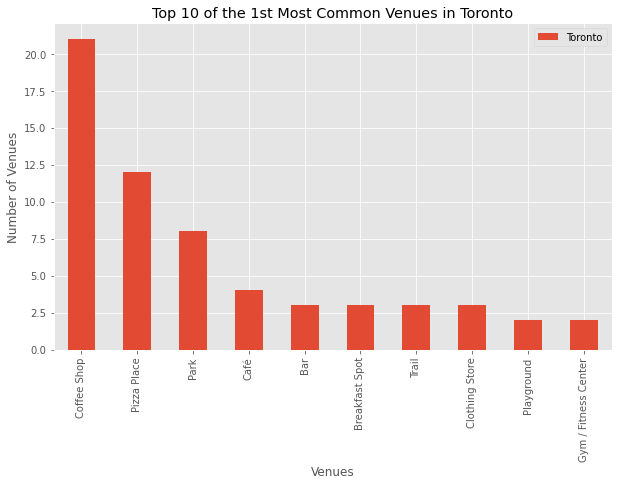

In [55]:
# step 2: plot data
Toronto_1st_com.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venues') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Top 10 of the 1st Most Common Venues in Toronto') # add title to the plot

plt.show()

In [56]:
Toronto_2nd_com = Toronto_merged['2nd Most Common Venue'].value_counts().to_frame().head()
Toronto_2nd_com.rename(columns = {'2nd Most Common Venue':'Venue_count'}, inplace = True)
Toronto_2nd_com.index.name = '2nd Most Common Venue'
Toronto_2nd_com

Venue_count
2nd Most Common Venue             
Coffee Shop                     10
Café                             9
Park                             7
Sandwich Place                   7
Yoga Studio                      5

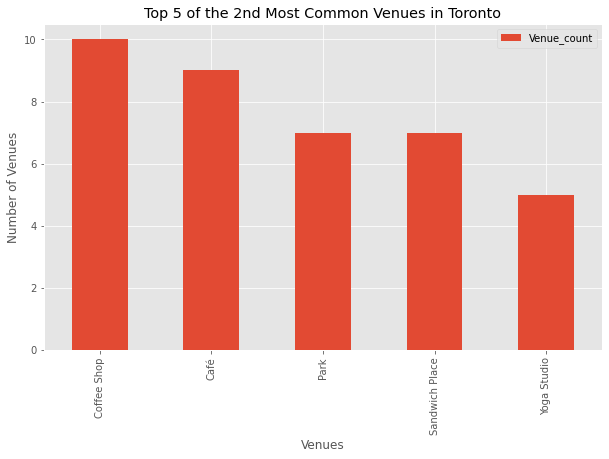

In [57]:
# step 2: plot data
Toronto_2nd_com.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venues') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Top 5 of the 2nd Most Common Venues in Toronto') # add title to the plot

plt.show()

In [58]:
Toronto_3rd_com = Toronto_merged['3rd Most Common Venue'].value_counts().to_frame().head()
Toronto_3rd_com.rename(columns = {'3rd Most Common Venue':'Venue_count'}, inplace = True)
Toronto_3rd_com.index.name = '3rd Most Common Venue'
Toronto_3rd_com

Venue_count
3rd Most Common Venue             
Yoga Studio                      7
Restaurant                       6
Café                             5
Drugstore                        5
Coffee Shop                      5

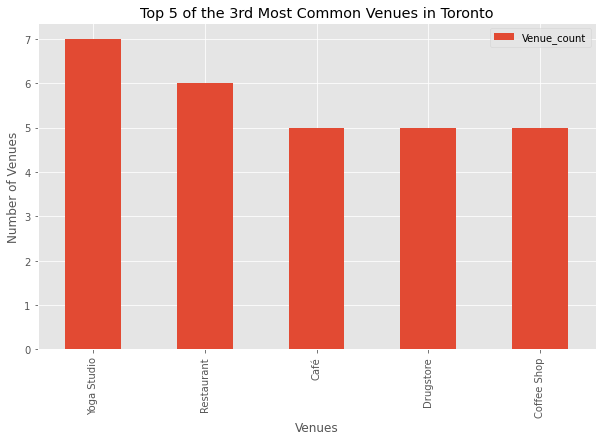

In [59]:
# step 2: plot data
Toronto_3rd_com.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venues') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Top 5 of the 3rd Most Common Venues in Toronto') # add title to the plot

plt.show()

In [60]:
Toronto_merged['4th Most Common Venue'].value_counts().to_frame().head()

4th Most Common Venue
Yoga Studio                      7
Bar                              6
Diner                            5
Café                             4
Coffee Shop                      4

In [61]:
Toronto_merged['5th Most Common Venue'].value_counts().to_frame().head()

5th Most Common Venue
Discount Store                      7
Yoga Studio                         6
Diner                               5
Donut Shop                          4
Dog Run                             4

In [62]:
Toronto_merged['6th Most Common Venue'].value_counts().to_frame().head()

6th Most Common Venue
Discount Store                          10
Distribution Center                      7
Diner                                    6
Dog Run                                  5
Dim Sum Restaurant                       5

In [63]:
Toronto_merged['7th Most Common Venue'].value_counts().to_frame().head()

7th Most Common Venue
Distribution Center                      9
Discount Store                           8
Dog Run                                  8
Diner                                    7
Restaurant                               6

In [64]:
Toronto_merged['8th Most Common Venue'].value_counts().to_frame().head()

8th Most Common Venue
Distribution Center                      9
Dog Run                                  9
Doner Restaurant                         8
Discount Store                           8
Donut Shop                               5

In [65]:
Toronto_merged['9th Most Common Venue'].value_counts().to_frame().head()

9th Most Common Venue
Donut Shop                              11
Dog Run                                 10
Distribution Center                      8
Doner Restaurant                         7
Burger Joint                             4

In [66]:
Toronto_merged['10th Most Common Venue'].value_counts().to_frame().head()

10th Most Common Venue
Doner Restaurant                      10
Donut Shop                             8
Drugstore                              7
Dog Run                                6
Beer Store                             4

Visualize the Toronto Neighborhoods clustered

In [67]:
plotCluster(T_lat, T_lon, Toronto_merged)

## Examine the 5 Toronto Clusters

## Cluster 1

In [68]:
T_Cluster1 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(4, Toronto_merged.shape[1]))]].reset_index(drop = True)
T_Cluster1.shape

(35, 12)

In [69]:
T_clus1 = T_Cluster1['1st Most Common Venue'].value_counts().to_frame().head(10)
T_clus1.rename(columns = {'1st Most Common Venue':'Cluster1'}, inplace = True)
T_clus1.index.name = '1st Most Common Venue'
T_clus1

Cluster1
1st Most Common Venue          
Pizza Place                   4
Trail                         3
Gym / Fitness Center          2
Grocery Store                 2
Breakfast Spot                2
Field                         1
College Stadium               1
Bar                           1
Food Truck                    1
Airport Lounge                1

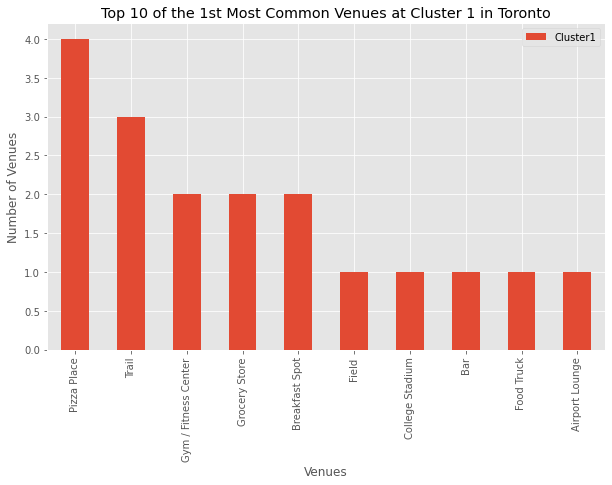

In [70]:
# step 2: plot data
T_clus1.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venues') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Top 10 of the 1st Most Common Venues at Cluster 1 in Toronto') # add title to the plot

plt.show()

## Cluster 2

In [71]:
T_Cluster2 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + list(range(4, Toronto_merged.shape[1]))]].reset_index(drop = True)
T_Cluster2.shape

(10, 12)

In [72]:
T_clus2 = T_Cluster2['1st Most Common Venue'].value_counts().to_frame()
T_clus2.rename(columns = {'1st Most Common Venue':'Cluster2'}, inplace = True)
T_clus2.index.name = '1st Most Common Venue'
T_clus2

Cluster2
1st Most Common Venue          
Park                          7
Playground                    1
Airport                       1
Food & Drink Shop             1

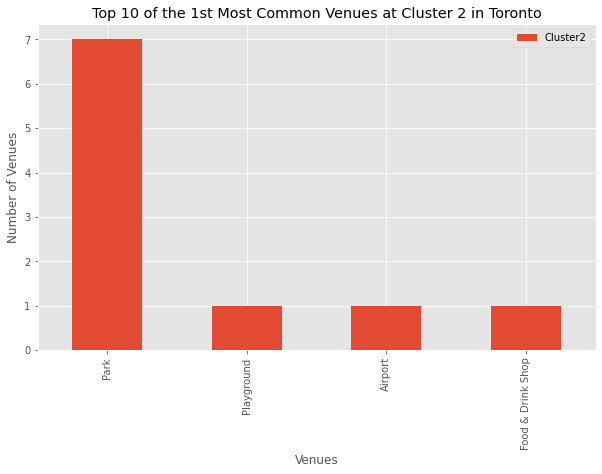

In [73]:
# step 2: plot data
T_clus2.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venues') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Top 10 of the 1st Most Common Venues at Cluster 2 in Toronto') # add title to the plot

plt.show()

In [74]:
T_clus1_2 = pd.merge(T_clus1, T_clus2, on='1st Most Common Venue', how='outer')


## Cluster 3

In [75]:
T_Cluster3 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[1] + list(range(4, Toronto_merged.shape[1]))]].reset_index(drop = True)
T_Cluster3.shape

(51, 12)

In [76]:
T_Cluster3.head()

Borough  Cluster Labels 1st Most Common Venue  \
0        North York               2           Pizza Place   
1  Downtown Toronto               2           Coffee Shop   
2        North York               2        Clothing Store   
3  Downtown Toronto               2           Coffee Shop   
4        North York               2   Japanese Restaurant   

  2nd Most Common Venue 3rd Most Common Venue  4th Most Common Venue  \
0           Coffee Shop          Hockey Arena  Portuguese Restaurant   
1                  Park                   Pub                 Bakery   
2     Accessories Store              Boutique              Gift Shop   
3           Yoga Studio                  Bank               Beer Bar   
4                   Gym  Caribbean Restaurant                   Café   

    5th Most Common Venue        6th Most Common Venue 7th Most Common Venue  \
0            Intersection  Eastern European Restaurant     Electronics Store   
1                    Café               Breakfast Spot               Theater   
2  Furniture / Home Store                  Event Space           Coffee Shop   
3           Smoothie Shop               Sandwich Place            Restaurant   
4        Doner Restaurant           Dim Sum Restaurant                 Diner   

  8th Most Common Venue  9th Most Common Venue 10th Most Common Venue  
0           Escape Room   Ethiopian Restaurant    Dumpling Restaurant  
1            Shoe Store      French Restaurant             Beer Store  
2         Women's Store  Vietnamese Restaurant        Airport Service  
3                  Café     Chinese Restaurant  Portuguese Restaurant  
4        Discount Store    Distribution Center                Dog Run

In [77]:
T_clus3 = T_Cluster3['1st Most Common Venue'].value_counts().to_frame().head(10)
T_clus3.rename(columns = {'1st Most Common Venue':'Cluster3'}, inplace = True)
T_clus3.index.name = '1st Most Common Venue'
T_clus3

Cluster3
1st Most Common Venue          
Coffee Shop                  21
Pizza Place                   8
Café                          3
Clothing Store                3
Bar                           2
Japanese Restaurant           1
Dessert Shop                  1
Gym                           1
Hotel                         1
Park                          1

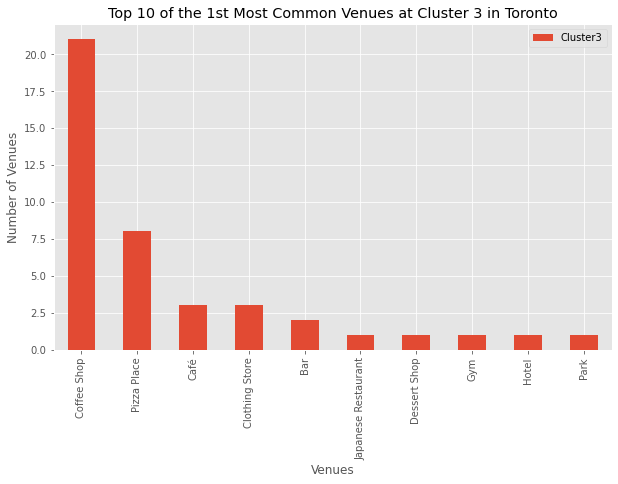

In [78]:
# step 2: plot data
T_clus3.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venues') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Top 10 of the 1st Most Common Venues at Cluster 3 in Toronto') # add title to the plot

plt.show()

In [79]:
T_clus1_2_3 = pd.merge(T_clus1_2, T_clus3, on='1st Most Common Venue', how='outer')


## Cluster 4

In [80]:
T_Cluster4 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[[1] + list(range(4, Toronto_merged.shape[1]))]].reset_index(drop = True)
T_Cluster4.shape

(1, 12)

In [81]:
T_clus4 = T_Cluster4['1st Most Common Venue'].value_counts().to_frame().head(10)
T_clus4.rename(columns = {'1st Most Common Venue':'Cluster4'}, inplace = True)
T_clus4.index.name = '1st Most Common Venue'
T_clus4

Cluster4
1st Most Common Venue          
Print Shop                    1

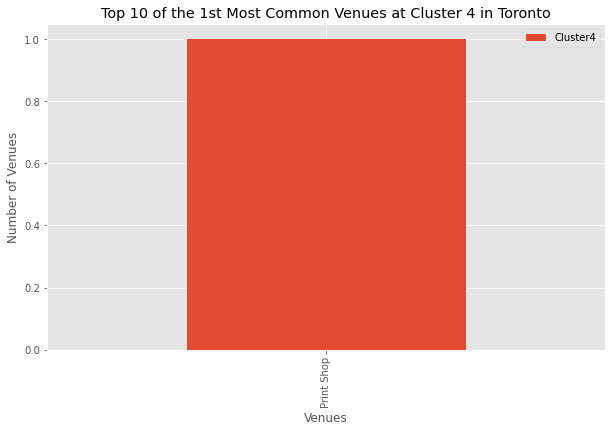

In [82]:
# step 2: plot data
T_clus4.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venues') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Top 10 of the 1st Most Common Venues at Cluster 4 in Toronto') # add title to the plot

plt.show()

In [83]:
T_clus1_2_3_4 = pd.merge(T_clus1_2_3, T_clus4, on='1st Most Common Venue', how='outer')


## Cluster 5

In [84]:
T_Cluster5 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 4, Toronto_merged.columns[[1] + list(range(4, Toronto_merged.shape[1]))]].reset_index(drop = True)
T_Cluster5.shape

(3, 12)

In [85]:
T_clus5 = T_Cluster5['1st Most Common Venue'].value_counts().to_frame().head(10)
T_clus5.rename(columns = {'1st Most Common Venue':'Cluster5'}, inplace = True)
T_clus5.index.name = '1st Most Common Venue'
T_clus5

Cluster5
1st Most Common Venue               
Construction & Landscaping         2
Baseball Field                     1

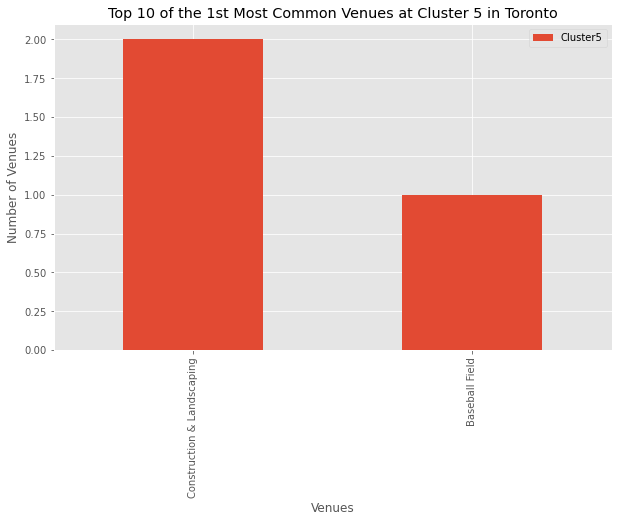

In [86]:
# step 2: plot data
T_clus5.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venues') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Top 10 of the 1st Most Common Venues at Cluster 5 in Toronto') # add title to the plot

plt.show()

In [87]:
T_clus1_2_3_4_5 = pd.merge(T_clus1_2_3_4, T_clus5, on='1st Most Common Venue', how='outer')
T_clus1_2_3_4_5

Cluster1  Cluster2  Cluster3  Cluster4  Cluster5
1st Most Common Venue                                                       
Pizza Place                      4.0       NaN       8.0       NaN       NaN
Trail                            3.0       NaN       NaN       NaN       NaN
Gym / Fitness Center             2.0       NaN       NaN       NaN       NaN
Grocery Store                    2.0       NaN       NaN       NaN       NaN
Breakfast Spot                   2.0       NaN       NaN       NaN       NaN
Field                            1.0       NaN       NaN       NaN       NaN
College Stadium                  1.0       NaN       NaN       NaN       NaN
Bar                              1.0       NaN       2.0       NaN       NaN
Food Truck                       1.0       NaN       NaN       NaN       NaN
Airport Lounge                   1.0       NaN       NaN       NaN       NaN
Park                             NaN       7.0       1.0       NaN       NaN
Playground                       NaN       1.0       NaN       NaN       NaN
Airport                          NaN       1.0       NaN       NaN       NaN
Food & Drink Shop                NaN       1.0       NaN       NaN       NaN
Coffee Shop                      NaN       NaN      21.0       NaN       NaN
Café                             NaN       NaN       3.0       NaN       NaN
Clothing Store                   NaN       NaN       3.0       NaN       NaN
Japanese Restaurant              NaN       NaN       1.0       NaN       NaN
Dessert Shop                     NaN       NaN       1.0       NaN       NaN
Gym                              NaN       NaN       1.0       NaN       NaN
Hotel                            NaN       NaN       1.0       NaN       NaN
Print Shop                       NaN       NaN       NaN       1.0       NaN
Construction & Landscaping       NaN       NaN       NaN       NaN       2.0
Baseball Field                   NaN       NaN       NaN       NaN       1.0

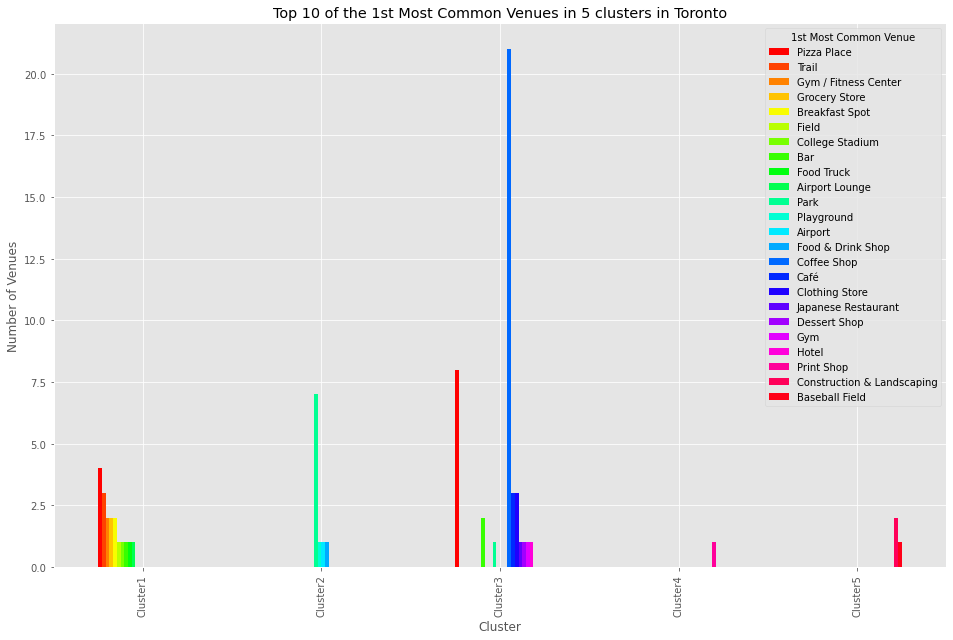

In [160]:
# step 2: plot data
T_clus1_2_3_4_5.T.plot(kind='bar', figsize=(16, 10), colormap='hsv')

plt.xlabel('Cluster') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Top 10 of the 1st Most Common Venues in 5 clusters in Toronto') # add title to the plot

plt.show()

# 2. NewYork DataSet

In [89]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [90]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [91]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [92]:
len(neighborhoods_data)

306

In [93]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Then let's loop through the data and fill the dataframe one row at a time.

In [94]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [95]:
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [96]:
print(neighborhoods.shape)
print('There are {} uniques neighborhoods.'.format(len(neighborhoods['Neighborhood'].unique())))
print('There are {} uniques Boroughs.'.format(len(neighborhoods['Borough'].unique())))

(306, 4)
There are 302 uniques neighborhoods.
There are 5 uniques Boroughs.


In [97]:
LatLon_NY = returnLatLon('New York City, NY')
latitude= LatLon_NY[0]
longitude = LatLon_NY[1]

print('The geograpical coordinates of Toronto are latitude = {}, Longitude = {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are latitude = 40.7127281, Longitude = -74.0060152.


## create map of New York with its neighborhoods superimposed onit


In [98]:
plotCity(latitude, longitude, neighborhoods)

# Explore Neighborhood in NY

In [99]:

ny_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )



Examine the shapes of NY venus

In [100]:
print(ny_venues.shape)
ny_venues.head()

(10145, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

              Venue  Venue Latitude  Venue Longitude  Venue Category  
0  Lollipops Gelato       40.894123       -73.845892    Dessert Shop  
1          Rite Aid       40.896649       -73.844846        Pharmacy  
2         Walgreens       40.896528       -73.844700        Pharmacy  
3  Carvel Ice Cream       40.890487       -73.848568  Ice Cream Shop  
4           Dunkin'       40.890459       -73.849089      Donut Shop

### Determine the top 10 venue categories in Newyork

In [101]:
ny_venue_category = ny_venues[['Venue Category']]
ny_venue_category.head()

Venue Category
0    Dessert Shop
1        Pharmacy
2        Pharmacy
3  Ice Cream Shop
4      Donut Shop

In [102]:
ny_top_10_venues = ny_venue_category['Venue Category'].value_counts().to_frame().head(10)
ny_top_10_venues.rename(columns = {'Venue Category':'Newyork'}, inplace = True)
ny_top_10_venues.index.name = 'Venue Category'
ny_top_10_venues

Newyork
Venue Category             
Pizza Place             439
Italian Restaurant      316
Coffee Shop             312
Deli / Bodega           268
Bakery                  227
Bar                     227
Chinese Restaurant      226
Grocery Store           195
Sandwich Place          187
Café                    180

## Top 10 Venues in Toronto and New York Cities

In [103]:
Top_10_T_ny = pd.merge(T_top_10_venues, ny_top_10_venues, on='Venue Category', how='outer')
Top_10_T_ny

Toronto  Newyork
Venue Category                       
Coffee Shop            190.0    312.0
Café                    93.0    180.0
Restaurant              66.0      NaN
Park                    51.0      NaN
Pizza Place             49.0    439.0
Hotel                   45.0      NaN
Sandwich Place          43.0    187.0
Bakery                  42.0    227.0
Japanese Restaurant     41.0      NaN
Italian Restaurant      39.0    316.0
Deli / Bodega            NaN    268.0
Bar                      NaN    227.0
Chinese Restaurant       NaN    226.0
Grocery Store            NaN    195.0

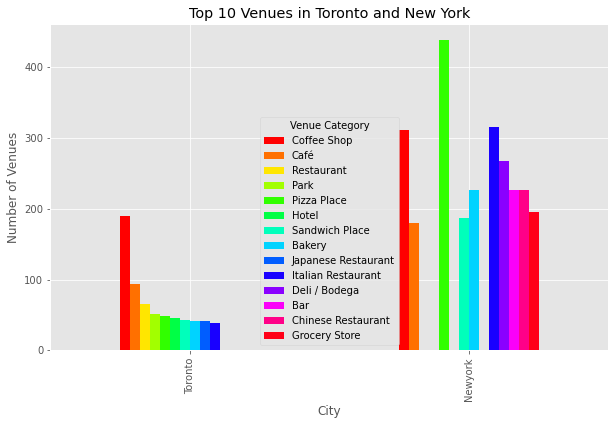

In [104]:
# step 2: plot data
Top_10_T_ny.T.plot(kind='bar', figsize=(10, 6), colormap='hsv')

plt.xlabel('City') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Top 10 Venues in Toronto and New York') # add title to the plot

plt.show()

Check how many venues returened for each neighborhood

In [105]:
ny_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                               
Allerton                                      31                      31   
Annadale                                      11                      11   
Arden Heights                                  5                       5   
Arlington                                      6                       6   
Arrochar                                      22                      22   
Arverne                                       20                      20   
Astoria                                      100                     100   
Astoria Heights                               13                      13   
Auburndale                                    22                      22   
Bath Beach                                    47                      47   
Battery Park City                             66                      66   
Bay Ridge                                     80                      80   
Bay Terrace                                   47                      47   
Baychester                                    20                      20   
Bayside                                       74                      74   
Bayswater                                      1                       1   
Bedford Park                                  36                      36   
Bedford Stuyvesant                            28                      28   
Beechhurst                                    17                      17   
Bellaire                                      13                      13   
Belle Harbor                                  17                      17   
Bellerose                                     19                      19   
Belmont                                       97                      97   
Bensonhurst                                   36                      36   
Bergen Beach                                   7                       7   
Blissville                                    18                      18   
Bloomfield                                     4                       4   
Boerum Hill                                   90                      90   
Borough Park                                  22                      22   
Breezy Point                                   5                       5   
Briarwood                                     10                      10   
Brighton Beach                                43                      43   
Broad Channel                                  5                       5   
Broadway Junction                             21                      21   
Bronxdale                                     14                      14   
Brooklyn Heights                             100                     100   
Brookville                                     2                       2   
Brownsville                                   16                      16   
Bulls Head                                    45                      45   
Bushwick                                      70                      70   
Butler Manor                                   4                       4   
Cambria Heights                               11                      11   
Canarsie                                       6                       6   
Carnegie Hill                                 90                      90   
Carroll Gardens                              100                     100   
Castle Hill                                    8                       8   
Castleton Corners                             15                      15   
Central Harlem                                45                      45   
Charleston                                    29                      29   
Chelsea                                      106                     106   
Chinatown                                    100                     100   

Let's find out how many unique categories can be curated from all returned venues

In [106]:
print('There are {} uniques categories.'.format(len(ny_venues['Venue Category'].unique())))
print('There are {} uniques neighborhoods.'.format(len(ny_venues['Neighborhood'].unique())))

There are 430 uniques categories.
There are 302 uniques neighborhoods.


Determine how many venues are returend per Borough

In [107]:
ny_b_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
ny_b_merged = ny_b_merged.join(ny_venues.set_index('Neighborhood'), on='Neighborhood')
ny_b_merged.head()

Borough Neighborhood   Latitude  Longitude  Neighborhood Latitude  \
0   Bronx    Wakefield  40.894705 -73.847201              40.894705   
0   Bronx    Wakefield  40.894705 -73.847201              40.894705   
0   Bronx    Wakefield  40.894705 -73.847201              40.894705   
0   Bronx    Wakefield  40.894705 -73.847201              40.894705   
0   Bronx    Wakefield  40.894705 -73.847201              40.894705   

   Neighborhood Longitude             Venue  Venue Latitude  Venue Longitude  \
0              -73.847201  Lollipops Gelato       40.894123       -73.845892   
0              -73.847201          Rite Aid       40.896649       -73.844846   
0              -73.847201         Walgreens       40.896528       -73.844700   
0              -73.847201  Carvel Ice Cream       40.890487       -73.848568   
0              -73.847201           Dunkin'       40.890459       -73.849089   

   Venue Category  
0    Dessert Shop  
0        Pharmacy  
0        Pharmacy  
0  Ice Cream Shop  
0      Donut Shop

In [108]:
ny_b_merged = ny_b_merged[['Borough', 'Venue']]
ny_b_merged = ny_b_merged.groupby('Borough').count()
ny_b_merged

Venue
Borough             
Bronx           1217
Brooklyn        2772
Manhattan       3271
Queens          2227
Staten Island   1004

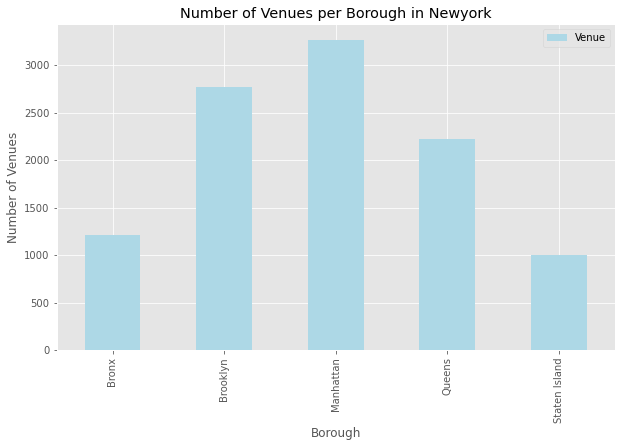

In [109]:
# step 2: plot data
ny_b_merged.plot(kind='bar', figsize=(10, 6), color = 'lightblue')

plt.xlabel('Borough') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Number of Venues per Borough in Newyork') # add title to the plot

plt.show()

# Analyze each Nieghborhood in Ny

In [110]:
ny_onehot = returnOnehot(ny_venues)
ny_onehot.head()


Neighborhood  Accessories Store  Adult Boutique  Afghan Restaurant  \
0    Wakefield                  0               0                  0   
1    Wakefield                  0               0                  0   
2    Wakefield                  0               0                  0   
3    Wakefield                  0               0                  0   
4    Wakefield                  0               0                  0   

   African Restaurant  Airport Terminal  American Restaurant  Antique Shop  \
0                   0                 0                    0             0   
1                   0                 0                    0             0   
2                   0                 0                    0             0   
3                   0                 0                    0             0   
4                   0                 0                    0             0   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0       0                 0                       0            0           0   
1       0                 0                       0            0           0   
2       0                 0                       0            0           0   
3       0                 0                       0            0           0   
4       0                 0                       0            0           0   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                    0                     0                 0   
1                    0                     0                 0   
2                    0                     0                 0   
3                    0                     0                 0   
4                    0                     0                 0   

   Athletics & Sports  Auditorium  Australian Restaurant  Austrian Restaurant  \
0                   0           0                      0                    0   
1                   0           0                      0                    0   
2                   0           0                      0                    0   
3                   0           0                      0                    0   
4                   0           0                      0                    0   

   Auto Garage  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  Bakery  \
0            0                0          0           0           0       0   
1            0                0          0           0           0       0   
2            0                0          0           0           0       0   
3            0                0          0           0           0       0   
4            0                0          0           0           0       0   

   Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  Bath House  \
0     0    0               0                 0                 0           0   
1     0    0               0                 0                 0           0   
2     0    0               0                 0                 0           0   
3     0    0               0                 0                 0           0   
4     0    0               0                 0                 0           0   

   Beach  Beach Bar  Beer Bar  Beer Garden  Beer Store  Big Box Store  \
0      0          0         0            0           0              0   
1      0          0         0            0           0              0   
2      0          0         0            0           0              0   
3      0          0         0            0           0              0   
4      0          0         0            0           0              0   

   Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  Board Shop  \
0                         0          0           0       0           0   
1                         0          0           0       0           0   
2                         0          0           0       0           0   
3                         0          0           0

In [111]:
ny_col = ny_onehot['Neighborhood']
ny_onehot.drop(labels=['Neighborhood'], axis=1, inplace = True)
ny_onehot.insert(0, 'Neighborhood', ny_col)
ny_onehot.head()

Neighborhood  Accessories Store  Adult Boutique  Afghan Restaurant  \
0    Wakefield                  0               0                  0   
1    Wakefield                  0               0                  0   
2    Wakefield                  0               0                  0   
3    Wakefield                  0               0                  0   
4    Wakefield                  0               0                  0   

   African Restaurant  Airport Terminal  American Restaurant  Antique Shop  \
0                   0                 0                    0             0   
1                   0                 0                    0             0   
2                   0                 0                    0             0   
3                   0                 0                    0             0   
4                   0                 0                    0             0   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0       0                 0                       0            0           0   
1       0                 0                       0            0           0   
2       0                 0                       0            0           0   
3       0                 0                       0            0           0   
4       0                 0                       0            0           0   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                    0                     0                 0   
1                    0                     0                 0   
2                    0                     0                 0   
3                    0                     0                 0   
4                    0                     0                 0   

   Athletics & Sports  Auditorium  Australian Restaurant  Austrian Restaurant  \
0                   0           0                      0                    0   
1                   0           0                      0                    0   
2                   0           0                      0                    0   
3                   0           0                      0                    0   
4                   0           0                      0                    0   

   Auto Garage  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  Bakery  \
0            0                0          0           0           0       0   
1            0                0          0           0           0       0   
2            0                0          0           0           0       0   
3            0                0          0           0           0       0   
4            0                0          0           0           0       0   

   Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  Bath House  \
0     0    0               0                 0                 0           0   
1     0    0               0                 0                 0           0   
2     0    0               0                 0                 0           0   
3     0    0               0                 0                 0           0   
4     0    0               0                 0                 0           0   

   Beach  Beach Bar  Beer Bar  Beer Garden  Beer Store  Big Box Store  \
0      0          0         0            0           0              0   
1      0          0         0            0           0              0   
2      0          0         0            0           0              0   
3      0          0         0            0           0              0   
4      0          0         0            0           0              0   

   Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  Board Shop  \
0                         0          0           0       0           0   
1                         0          0           0       0           0   
2                         0          0           0       0           0   
3                         0          0           0

In [112]:
ny_onehot.shape

(10145, 430)

In [113]:
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()


In [114]:
ny_grouped.head()

Neighborhood  Accessories Store  Adult Boutique  Afghan Restaurant  \
0       Allerton                0.0             0.0                0.0   
1       Annadale                0.0             0.0                0.0   
2  Arden Heights                0.0             0.0                0.0   
3      Arlington                0.0             0.0                0.0   
4       Arrochar                0.0             0.0                0.0   

   African Restaurant  Airport Terminal  American Restaurant  Antique Shop  \
0                 0.0               0.0             0.000000           0.0   
1                 0.0               0.0             0.181818           0.0   
2                 0.0               0.0             0.000000           0.0   
3                 0.0               0.0             0.000000           0.0   
4                 0.0               0.0             0.000000           0.0   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0     0.0               0.0                     0.0          0.0         0.0   
1     0.0               0.0                     0.0          0.0         0.0   
2     0.0               0.0                     0.0          0.0         0.0   
3     0.0               0.0                     0.0          0.0         0.0   
4     0.0               0.0                     0.0          0.0         0.0   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                  0.0                   0.0               0.0   
1                  0.0                   0.0               0.0   
2                  0.0                   0.0               0.0   
3                  0.0                   0.0               0.0   
4                  0.0                   0.0               0.0   

   Athletics & Sports  Auditorium  Australian Restaurant  Austrian Restaurant  \
0            0.000000         0.0                    0.0                  0.0   
1            0.000000         0.0                    0.0                  0.0   
2            0.000000         0.0                    0.0                  0.0   
3            0.000000         0.0                    0.0                  0.0   
4            0.045455         0.0                    0.0                  0.0   

   Auto Garage  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop    Bakery  \
0          0.0              0.0        0.0         0.0    0.000000  0.032258   
1          0.0              0.0        0.0         0.0    0.000000  0.000000   
2          0.0              0.0        0.0         0.0    0.000000  0.000000   
3          0.0              0.0        0.0         0.0    0.000000  0.000000   
4          0.0              0.0        0.0         0.0    0.045455  0.000000   

   Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  Bath House  \
0   0.0  0.0             0.0               0.0               0.0         0.0   
1   0.0  0.0             0.0               0.0               0.0         0.0   
2   0.0  0.0             0.0               0.0               0.0         0.0   
3   0.0  0.0             0.0               0.0               0.0         0.0   
4   0.0  0.0             0.0               0.0               0.0         0.0   

      Beach  Beach Bar  Beer Bar  Beer Garden  Beer Store  Big Box Store  \
0  0.000000        0.0       0.0          0.0         0.0            0.0   
1  0.000000        0.0       0.0          0.0         0.0            0.0   
2  0.000000        0.0       0.0          0.0         0.0            0.0   
3  0.000000        0.0       0.0          0.0         0.0            0.0   
4  0.045455        0.0       0.0          0.0         0.0            0.0   

   Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  Board Shop  \
0                       0.0        0.0         0.0     0.0         0.0   
1                       0.0        0.0         0.0     0.0         0.0   
2                       0.0        0.0         0.0     0.0         0.0   
3         

Let's write function to order the venues in descending order

Let's create a new dataframe and display the top ten venues for each NY neighborhood

In [115]:
ny_venues_sorted = return_sorted(ny_grouped)
ny_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0       Allerton           Pizza Place         Deli / Bodega   
1       Annadale   American Restaurant           Pizza Place   
2  Arden Heights         Deli / Bodega              Pharmacy   
3      Arlington         Deli / Bodega         Grocery Store   
4       Arrochar              Bus Stop    Italian Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0        Discount Store           Supermarket                   Spa   
1                 Diner         Deli / Bodega          Dance Studio   
2           Coffee Shop              Bus Stop           Pizza Place   
3           Coffee Shop              Bus Stop          Home Service   
4         Deli / Bodega                 Beach        Cosmetics Shop   

       6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0         Chinese Restaurant           Gas Station            Playground   
1              Train Station            Restaurant                  Park   
2          Fish & Chips Shop               Factory    Falafel Restaurant   
3              Boat or Ferry    Falafel Restaurant                  Farm   
4  Middle Eastern Restaurant              Pharmacy        Sandwich Place   

  9th Most Common Venue 10th Most Common Venue  
0                Bakery               Pharmacy  
1                  Food   Fast Food Restaurant  
2                  Farm         Farmers Market  
3        Farmers Market   Fast Food Restaurant  
4          Liquor Store             Bagel Shop

# Cluster NY Neighborhood

Run K-means to cluster NY Neighborhood to 5 cluster

In [116]:
# set number of clusters
kclusters = 5

ny_grouped_clustering = ny_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 3, 3, 3, 0, 0, 3, 0, 3], dtype=int32)

In [117]:
print(len(kmeans.labels_))

302


In [118]:
# add clustering labels
ny_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
#neighborhoods_venues_sorted.head()
ny_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
ny_merged = ny_merged.join(ny_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ny_merged.head() # check the last columns!

Borough Neighborhood   Latitude  Longitude  Cluster Labels  \
0   Bronx    Wakefield  40.894705 -73.847201               3   
1   Bronx   Co-op City  40.874294 -73.829939               3   
2   Bronx  Eastchester  40.887556 -73.827806               3   
3   Bronx    Fieldston  40.895437 -73.905643               0   
4   Bronx    Riverdale  40.890834 -73.912585               0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0              Pharmacy            Donut Shop           Gas Station   
1           Bus Station     Accessories Store           Pizza Place   
2           Bus Station  Caribbean Restaurant         Deli / Bodega   
3  Medical Supply Store                 River                 Plaza   
4                  Park                  Bank          Home Service   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0           Pizza Place            Laundromat        Ice Cream Shop   
1  Fast Food Restaurant         Grocery Store    Chinese Restaurant   
2                 Diner        Cosmetics Shop       Automotive Shop   
3     Fish & Chips Shop               Exhibit            Eye Doctor   
4                   Gym         Moving Target                 Plaza   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0        Sandwich Place          Dessert Shop         Deli / Bodega   
1                  Park                   Bar            Bagel Shop   
2         Bowling Alley           Pizza Place         Metro Station   
3               Factory    Falafel Restaurant                  Farm   
4            Food Truck           Bus Station            Playground   

  10th Most Common Venue  
0     Falafel Restaurant  
1                  Trail  
2      Food & Drink Shop  
3         Farmers Market  
4                   Farm

Remove rows with empty Cluster labels

In [119]:

ny_merged.dropna(subset=['Cluster Labels'], inplace=True)


In [120]:
Cus2_3 = ny_merged[(ny_merged['Cluster Labels'] == 2)] # or (ny_merged['Cluster Labels'] == 3)]
Cus2_3

Borough  Neighborhood   Latitude  Longitude  Cluster Labels  \
27           Bronx  Clason Point  40.806551 -73.854144               2   
192         Queens    Somerville  40.597711 -73.796648               2   
203  Staten Island     Todt Hill  40.597069 -74.111329               2   
257  Staten Island  Howland Hook  40.638433 -74.186223               2   

    1st Most Common Venue      2nd Most Common Venue 3rd Most Common Venue  \
27                   Park  South American Restaurant              Bus Stop   
192                  Park                Yoga Studio               Exhibit   
203                  Park                Yoga Studio               Exhibit   
257         Boat or Ferry                Yoga Studio           Flower Shop   

    4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
27      Convenience Store         Grocery Store                  Pool   
192               Factory    Falafel Restaurant                  Farm   
203               Factory    Falafel Restaurant                  Farm   
257               Factory    Falafel Restaurant                  Farm   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
27         Scenic Lookout         Boat or Ferry           Yoga Studio   
192        Farmers Market  Fast Food Restaurant                 Field   
203        Farmers Market  Fast Food Restaurant                 Field   
257        Farmers Market  Fast Food Restaurant                 Field   

    10th Most Common Venue  
27      Falafel Restaurant  
192    Filipino Restaurant  
203    Filipino Restaurant  
257    Filipino Restaurant

Convert the Cluster Labels to integer as cluster value in the plotCluster function must be integer

In [121]:
ny_merged['Cluster Labels'] = ny_merged['Cluster Labels'].astype('int64')

TOP five venues in from New york Neighboroods

In [122]:
ny_merged.columns

Index(['Borough', 'Neighborhood', 'Latitude', 'Longitude', 'Cluster Labels',
       '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

In [123]:
ny_1st_com = ny_merged['1st Most Common Venue'].value_counts().to_frame().head(10)
ny_1st_com.rename(columns = {'1st Most Common Venue':'Newyork'}, inplace = True)
ny_1st_com.index.name = '1st Most Common Venue'
ny_1st_com

Newyork
1st Most Common Venue         
Pizza Place                 31
Deli / Bodega               29
Italian Restaurant          28
Coffee Shop                 13
Chinese Restaurant          12
Bar                         12
Grocery Store               11
Park                        11
Bus Station                 10
Beach                        8

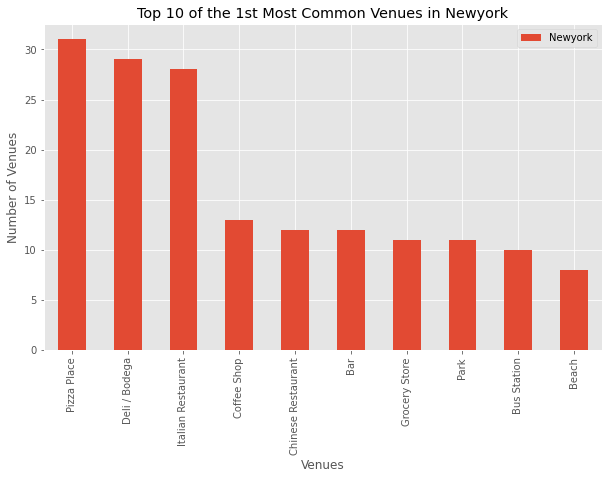

In [124]:
# step 2: plot data
ny_1st_com.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venues') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Top 10 of the 1st Most Common Venues in Newyork') # add title to the plot

plt.show()

### Compare the Top 10 1st Common Venues in Toronto and Newyork

In [125]:
Toronto_ny_1st_com = pd.merge(Toronto_1st_com, ny_1st_com, on='1st Most Common Venue', how='outer')
Toronto_ny_1st_com

Toronto  Newyork
1st Most Common Venue                  
Coffee Shop               21.0     13.0
Pizza Place               12.0     31.0
Park                       8.0     11.0
Café                       4.0      NaN
Bar                        3.0     12.0
Breakfast Spot             3.0      NaN
Trail                      3.0      NaN
Clothing Store             3.0      NaN
Playground                 2.0      NaN
Gym / Fitness Center       2.0      NaN
Deli / Bodega              NaN     29.0
Italian Restaurant         NaN     28.0
Chinese Restaurant         NaN     12.0
Grocery Store              NaN     11.0
Bus Station                NaN     10.0
Beach                      NaN      8.0

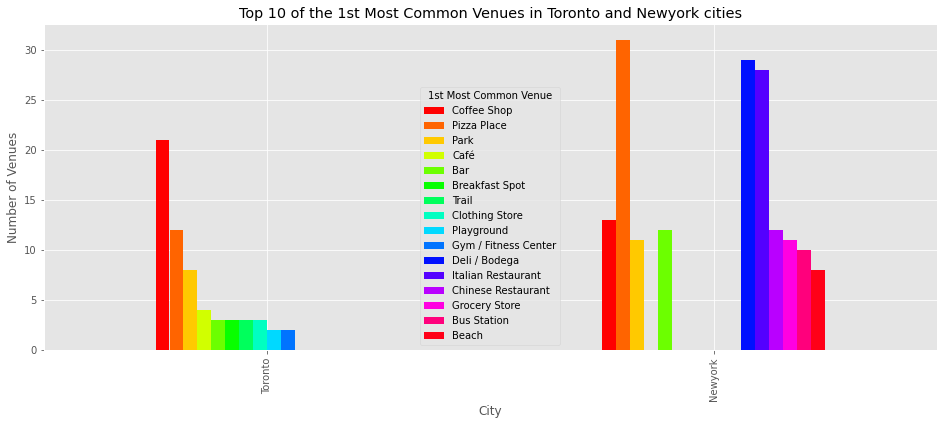

In [126]:
# step 2: plot data
Toronto_ny_1st_com.T.plot(kind='bar', figsize=(16, 6), colormap = 'hsv')

plt.xlabel('City') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Top 10 of the 1st Most Common Venues in Toronto and Newyork cities') # add title to the plot

plt.show()

In [127]:
ny_merged['2nd Most Common Venue'].value_counts().to_frame().head()

2nd Most Common Venue
Italian Restaurant                     22
Pizza Place                            19
Deli / Bodega                          15
Coffee Shop                            15
Pharmacy                               12

In [128]:
ny_merged['3rd Most Common Venue'].value_counts().to_frame().head()

3rd Most Common Venue
Pizza Place                            32
Deli / Bodega                          13
Coffee Shop                            11
Sandwich Place                         11
Italian Restaurant                     10

In [129]:
ny_merged['4th Most Common Venue'].value_counts().to_frame().head()

4th Most Common Venue
Pizza Place                            18
Coffee Shop                            11
Chinese Restaurant                     10
Bakery                                  9
Bar                                     9

In [130]:
ny_merged['5th Most Common Venue'].value_counts().to_frame().head()

5th Most Common Venue
Yoga Studio                            12
Pizza Place                            12
Sandwich Place                          8
Chinese Restaurant                      8
Falafel Restaurant                      8

In [131]:
ny_merged['6th Most Common Venue'].value_counts().to_frame().head()

6th Most Common Venue
Chinese Restaurant                     12
Donut Shop                             11
Grocery Store                          11
Park                                   10
Pharmacy                                9

In [132]:
ny_merged['7th Most Common Venue'].value_counts().to_frame().head()

7th Most Common Venue
Sandwich Place                         15
Bakery                                 13
Pizza Place                            11
Grocery Store                          10
Falafel Restaurant                     10

In [133]:
ny_merged['8th Most Common Venue'].value_counts().to_frame().head()

8th Most Common Venue
Bakery                                   15
Farm                                     12
Pizza Place                              12
Farmers Market                           11
Fast Food Restaurant                     10

In [134]:
ny_merged['9th Most Common Venue'].value_counts().to_frame().head()

9th Most Common Venue
Farmers Market                           14
Pizza Place                              12
Fast Food Restaurant                     11
Field                                    10
Chinese Restaurant                        9

In [135]:
ny_merged['10th Most Common Venue'].value_counts().to_frame().head()

10th Most Common Venue
Fast Food Restaurant                      14
Falafel Restaurant                        12
Pizza Place                               11
Farmers Market                            11
Pharmacy                                   9

# Visualize the clustered NY neighborhoods 

In [136]:
plotCluster(latitude, longitude, ny_merged)

# Examine the 5 Ny Clusters

## Cluster 1

In [137]:
Cluster1 = ny_merged.loc[ny_merged['Cluster Labels'] == 0, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]].reset_index(drop = True)
Cluster1.shape

(145, 11)

In [138]:
ny_clus1 = Cluster1['1st Most Common Venue'].value_counts().to_frame().head(10)
ny_clus1.rename(columns = {'1st Most Common Venue':'Cluster1'}, inplace = True)
ny_clus1.index.name = '1st Most Common Venue'
ny_clus1

Cluster1
1st Most Common Venue          
Italian Restaurant           17
Coffee Shop                  13
Bar                          11
Park                          8
Caribbean Restaurant          7
Hotel                         5
Grocery Store                 5
Clothing Store                4
Deli / Bodega                 4
Chinese Restaurant            4

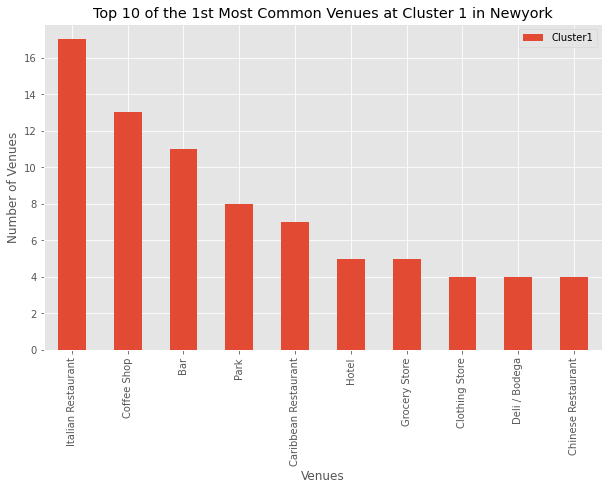

In [139]:
# step 2: plot data
ny_clus1.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venues') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Top 10 of the 1st Most Common Venues at Cluster 1 in Newyork') # add title to the plot

plt.show()

## Cluster 2

In [140]:
Cluster2 = ny_merged.loc[ny_merged['Cluster Labels'] == 1, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]].reset_index(drop = True)
Cluster2.shape

(4, 11)

In [141]:
ny_clus2 = Cluster2['1st Most Common Venue'].value_counts().to_frame().head(10)
ny_clus2.rename(columns = {'1st Most Common Venue':'Cluster2'}, inplace = True)
ny_clus2.index.name = '1st Most Common Venue'
ny_clus2

Cluster2
1st Most Common Venue          
Beach                         4

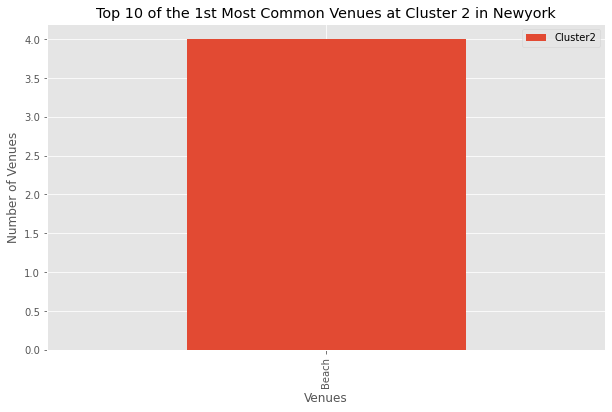

In [142]:
# step 2: plot data
ny_clus2.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venues') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Top 10 of the 1st Most Common Venues at Cluster 2 in Newyork') # add title to the plot

plt.show()

In [143]:
ny_clus1_2 = pd.merge(ny_clus1, ny_clus2, on='1st Most Common Venue', how='outer')


## Cluster 3

In [144]:
Cluster3 = ny_merged.loc[ny_merged['Cluster Labels'] == 2, ny_merged.columns[[1] + list(range(4, ny_merged.shape[1]))]].reset_index(drop = True)
Cluster3.shape

(4, 12)

In [145]:
Cluster3.head()

Neighborhood  Cluster Labels 1st Most Common Venue  \
0  Clason Point               2                  Park   
1    Somerville               2                  Park   
2     Todt Hill               2                  Park   
3  Howland Hook               2         Boat or Ferry   

       2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0  South American Restaurant              Bus Stop     Convenience Store   
1                Yoga Studio               Exhibit               Factory   
2                Yoga Studio               Exhibit               Factory   
3                Yoga Studio           Flower Shop               Factory   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0         Grocery Store                  Pool        Scenic Lookout   
1    Falafel Restaurant                  Farm        Farmers Market   
2    Falafel Restaurant                  Farm        Farmers Market   
3    Falafel Restaurant                  Farm        Farmers Market   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0         Boat or Ferry           Yoga Studio     Falafel Restaurant  
1  Fast Food Restaurant                 Field    Filipino Restaurant  
2  Fast Food Restaurant                 Field    Filipino Restaurant  
3  Fast Food Restaurant                 Field    Filipino Restaurant

In [146]:
ny_clus3 = Cluster3['1st Most Common Venue'].value_counts().to_frame().head(10)
ny_clus3.rename(columns = {'1st Most Common Venue':'Cluster3'}, inplace = True)
ny_clus3.index.name = '1st Most Common Venue'
ny_clus3

Cluster3
1st Most Common Venue          
Park                          3
Boat or Ferry                 1

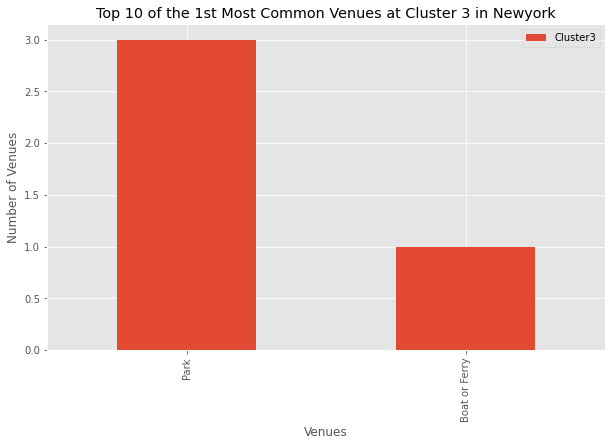

In [147]:
# step 2: plot data
ny_clus3.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venues') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Top 10 of the 1st Most Common Venues at Cluster 3 in Newyork') # add title to the plot

plt.show()

In [148]:
ny_clus1_2_3 = pd.merge(ny_clus1_2, ny_clus3, on='1st Most Common Venue', how='outer')


## Cluster 4

In [149]:
Cluster4 = ny_merged.loc[ny_merged['Cluster Labels'] == 3, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]].reset_index(drop = True)
Cluster4.shape

(151, 11)

In [150]:
ny_clus4 = Cluster4['1st Most Common Venue'].value_counts().to_frame().head(10)
ny_clus4.rename(columns = {'1st Most Common Venue':'Cluster4'}, inplace = True)
ny_clus4.index.name = '1st Most Common Venue'
ny_clus4

Cluster4
1st Most Common Venue          
Pizza Place                  29
Deli / Bodega                25
Italian Restaurant           11
Bus Station                   8
Chinese Restaurant            8
Bank                          7
Donut Shop                    7
Grocery Store                 6
Bagel Shop                    4
Pharmacy                      4

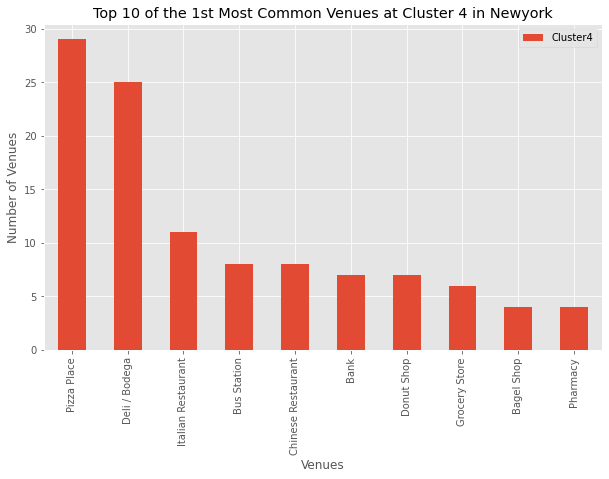

In [151]:
# step 2: plot data
ny_clus4.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venues') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Top 10 of the 1st Most Common Venues at Cluster 4 in Newyork') # add title to the plot

plt.show()

In [152]:
ny_clus1_2_3_4 = pd.merge(ny_clus1_2_3, ny_clus4, on='1st Most Common Venue', how='outer')


## Cluster 5

In [153]:
Cluster5 = ny_merged.loc[ny_merged['Cluster Labels'] == 4, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]].reset_index(drop = True)
Cluster5.shape

(2, 11)

In [154]:
ny_clus5 = Cluster5['1st Most Common Venue'].value_counts().to_frame().head(10)
ny_clus5.rename(columns = {'1st Most Common Venue':'Cluster5'}, inplace = True)
ny_clus5.index.name = '1st Most Common Venue'
ny_clus5

Cluster5
1st Most Common Venue          
Pool                          2

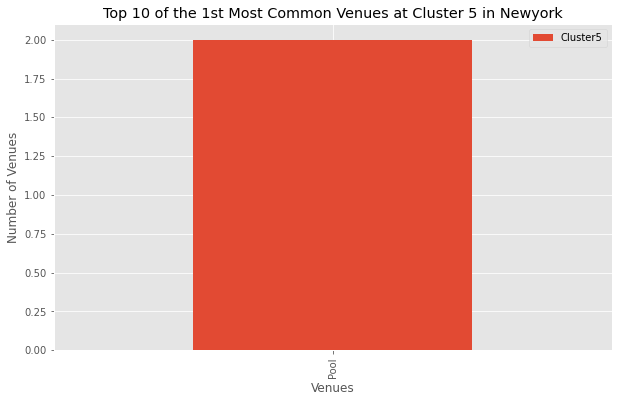

In [155]:
# step 2: plot data
ny_clus5.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venues') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Top 10 of the 1st Most Common Venues at Cluster 5 in Newyork') # add title to the plot

plt.show()

# Compare the number of venues returend per each cluster in both cities

In [156]:
data = {'Cluster':  ['Cluster 1', 'Cluster 2','Cluster 3', 'Cluster 4', 'Cluster 5'],
        'Toronto': [T_Cluster1.shape[0], T_Cluster2.shape[0],T_Cluster3.shape[0], T_Cluster4.shape[0], T_Cluster5.shape[0]],
         'Newyork': [Cluster1.shape[0], Cluster2.shape[0],Cluster3.shape[0], Cluster4.shape[0], Cluster5.shape[0]]
        }

venue_per_cluster = pd.DataFrame (data)
venue_per_cluster.set_index('Cluster', inplace = True)
venue_per_cluster


Toronto  Newyork
Cluster                    
Cluster 1       35      145
Cluster 2       10        4
Cluster 3       51        4
Cluster 4        1      151
Cluster 5        3        2

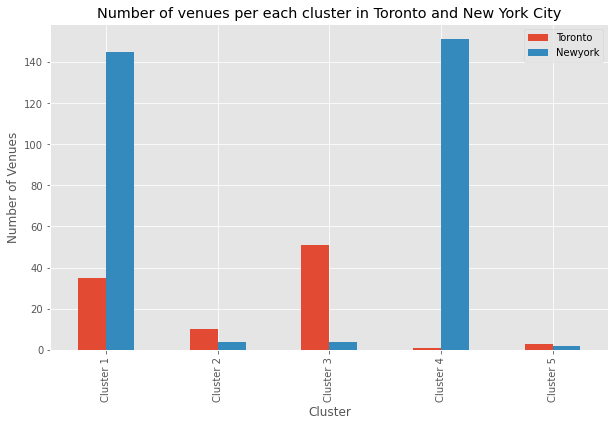

In [157]:
# step 2: plot data
venue_per_cluster.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Cluster') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Number of venues per each cluster in Toronto and New York City') # add title to the plot

plt.show()

## Top 10 1st most common clusters in New York City

In [158]:
ny_clus1_2_3_4_5 = pd.merge(ny_clus1_2_3_4, ny_clus5, on='1st Most Common Venue', how='outer')
ny_clus1_2_3_4_5

Cluster1  Cluster2  Cluster3  Cluster4  Cluster5
1st Most Common Venue                                                  
Italian Restaurant         17.0       NaN       NaN      11.0       NaN
Coffee Shop                13.0       NaN       NaN       NaN       NaN
Bar                        11.0       NaN       NaN       NaN       NaN
Park                        8.0       NaN       3.0       NaN       NaN
Caribbean Restaurant        7.0       NaN       NaN       NaN       NaN
Hotel                       5.0       NaN       NaN       NaN       NaN
Grocery Store               5.0       NaN       NaN       6.0       NaN
Clothing Store              4.0       NaN       NaN       NaN       NaN
Deli / Bodega               4.0       NaN       NaN      25.0       NaN
Chinese Restaurant          4.0       NaN       NaN       8.0       NaN
Beach                       NaN       4.0       NaN       NaN       NaN
Boat or Ferry               NaN       NaN       1.0       NaN       NaN
Pizza Place                 NaN       NaN       NaN      29.0       NaN
Bus Station                 NaN       NaN       NaN       8.0       NaN
Bank                        NaN       NaN       NaN       7.0       NaN
Donut Shop                  NaN       NaN       NaN       7.0       NaN
Bagel Shop                  NaN       NaN       NaN       4.0       NaN
Pharmacy                    NaN       NaN       NaN       4.0       NaN
Pool                        NaN       NaN       NaN       NaN       2.0

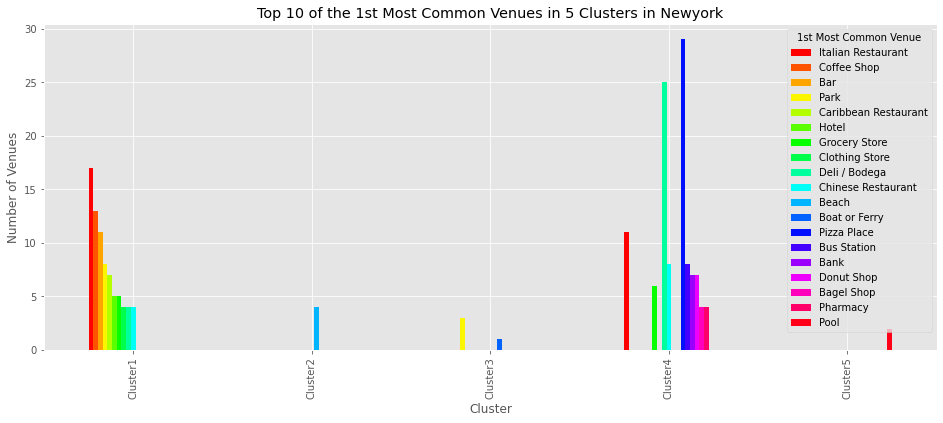

In [159]:
# step 2: plot data
ny_clus1_2_3_4_5.T.plot(kind='bar', figsize=(16, 6), colormap='hsv')

plt.xlabel('Cluster') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Top 10 of the 1st Most Common Venues in 5 Clusters in Newyork') # add title to the plot

plt.show()

# The End!!!